# Data Mining Project
Group 5:
- **Marcel Buczkowski 59426**
- **Emanuele Tartaglione 61294**
- **Alberto Fallocco 59378**

Time spent: 8 hours each

# Data preparation

First we imported the libraries and the data needed and processed them to be stored in adequate format.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import time
import random
import matplotlib.cm as cm
from collections import Counter
from matplotlib import pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from scipy.spatial.distance import pdist, squareform

In [3]:
df = pd.read_csv('fps.txt', sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,PDFDA0001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,PDFDA0002,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,PDFDA0003,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PDFDA0004,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,PDFDA0005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
with open('acts.txt', 'r') as file:
    targets_transactions, molecules, l = [], [], []
    for line in file.readlines():
        for w in line.split():
            if w.endswith(':'):
                molecules.append(w.rstrip(':'))
                if l:
                    targets_transactions.append(l)
                    l = []
            else:
                l.append(w)

targets = list({i for lst in targets_transactions for i in lst})         # it extracts unique list of all targets.
targets_dict = dict(zip(targets, range(len(targets))))                   # it creates dictionary which assigns unique integer for each target.
targets_transactions_ids = list(
    map(lambda sublist:
        list(map(lambda item: targets_dict.get(item, item), 
                 sublist)),targets_transactions))                        # it creates a transaction list with integers instead of strings

Then in our data frame we checked if there are any missing values.

In [5]:
na = False
for name, col in df.items():
    if col.isna().any():
        na = True
        df = df.fillna({name: 0})
if na:print('There were some missing values, they were filles with 0')

# Clustering

We began our analysis performing clustering. The first step was to choose the best method to do our analysis. We compared HAC and Kmeans.

In [6]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=30, random_state = 4)
df_pca = pca.fit_transform(df.iloc[:,1:])

methods = ['single', 'average', 'complete', 'ward']
for method in methods:
    hac = AgglomerativeClustering(linkage=method, n_clusters=4).fit(df_pca)
    sil_h = silhouette_score(df_pca, hac.labels_)   
    print(f"Method {method} silhouette score - {round(sil_h,4)}")

Method single silhouette score - 0.3523
Method average silhouette score - 0.3307
Method complete silhouette score - 0.2506
Method ward silhouette score - 0.0408


We used single linkage on the HAC algorithm since it has the best silhouette score.

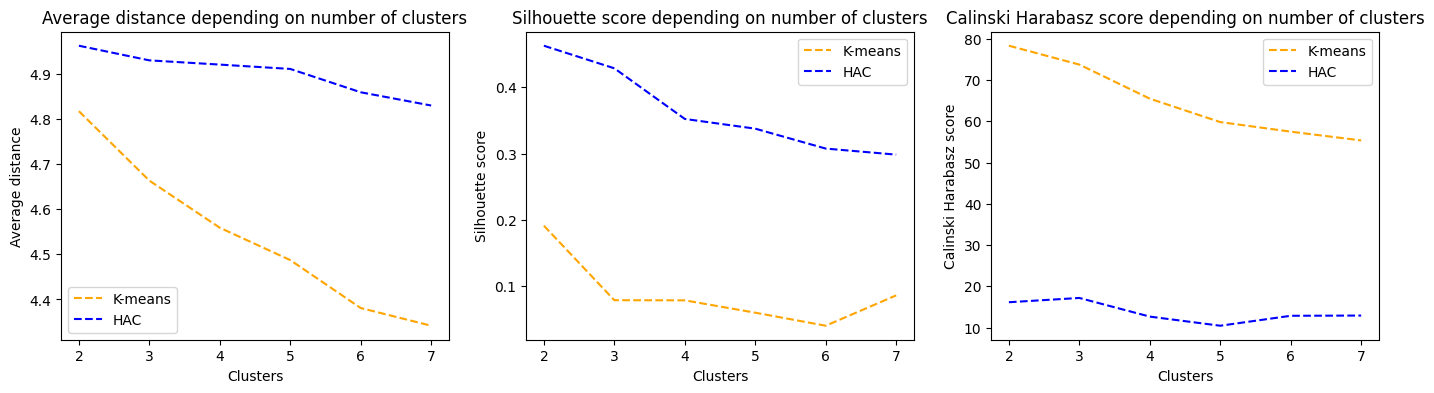

In [7]:
def avgDist(X, labels):
    D=pdist(X, metric='euclidean')
    dmatrix=squareform(D, checks=True)
    N=len(labels)
    L=list(set(labels))
    L.sort()
    result=0
    for i in L:
        Nc=sum(labels==i)
        S=0
        if Nc>1: S=np.sum(dmatrix[labels==i,:][:,labels==i])/(Nc*(Nc-1))
        result+=S*Nc/N
    return result

results_1 = {'sil_k': [], 'sil_h': [], 'calhar_k': [], 'calhar_h': [], 'dist_k': [], 'dist_h': []}
for K in range(2,8):
    kms = KMeans(n_clusters=K, random_state=0).fit(df_pca)
    hac = AgglomerativeClustering(linkage="single", n_clusters=K).fit(df_pca)
    sil_k = silhouette_score(df_pca, kms.labels_);results_1['sil_k'].append(sil_k)
    sil_h = silhouette_score(df_pca, hac.labels_);results_1['sil_h'].append(sil_h)
    calhar_k = calinski_harabasz_score(df_pca, kms.labels_);results_1['calhar_k'].append(calhar_k)
    calhar_h = calinski_harabasz_score(df_pca, hac.labels_);results_1['calhar_h'].append(calhar_h)
    dist_k = avgDist(df_pca, kms.labels_);results_1['dist_k'].append(dist_k)
    dist_h = avgDist(df_pca, hac.labels_);results_1['dist_h'].append(dist_h)

clusts = [2,3,4,5,6,7]
plt.figure(figsize=(17,4))
plt.subplot(1, 3, 1);plt.plot(clusts, results_1['dist_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_1['dist_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Average distance');plt.title('Average distance depending on number of clusters');plt.legend()
plt.subplot(1, 3, 2);plt.plot(clusts, results_1['sil_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_1['sil_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Silhouette score');plt.title('Silhouette score depending on number of clusters');plt.legend()
plt.subplot(1, 3, 3);plt.plot(clusts, results_1['calhar_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_1['calhar_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Calinski Harabasz score');plt.title('Calinski Harabasz score depending on number of clusters');plt.legend()
plt.show()

In [8]:
kms = KMeans(n_clusters=4, random_state=0).fit(df_pca)
print('Cluster distribution in Kmeans with 4 clusters')
for i, label in enumerate(set(kms.labels_)):
    print(f'Cluster {i+1}: {np.count_nonzero(kms.labels_==label)}')

Cluster distribution in Kmeans with 4 clusters
Cluster 1: 465
Cluster 2: 339
Cluster 3: 227
Cluster 4: 70


In [9]:
hac = AgglomerativeClustering(linkage="single", n_clusters=4).fit(df_pca)
print('Cluster distribution in HAC with 4 clusters')
for i, label in enumerate(set(hac.labels_)):
    print(f'Cluster {i+1}: {np.count_nonzero(hac.labels_==label)}')

Cluster distribution in HAC with 4 clusters
Cluster 1: 1093
Cluster 2: 3
Cluster 3: 4
Cluster 4: 1


Looking at the plots and the distribution of the data after applying Kmeans and HAC, we decided to use the Kmeans algorithm with 4 clusters. We did not choose the HAC algorithm since everything falls in one cluster even though the silhouette scores are better than the Kmeans.

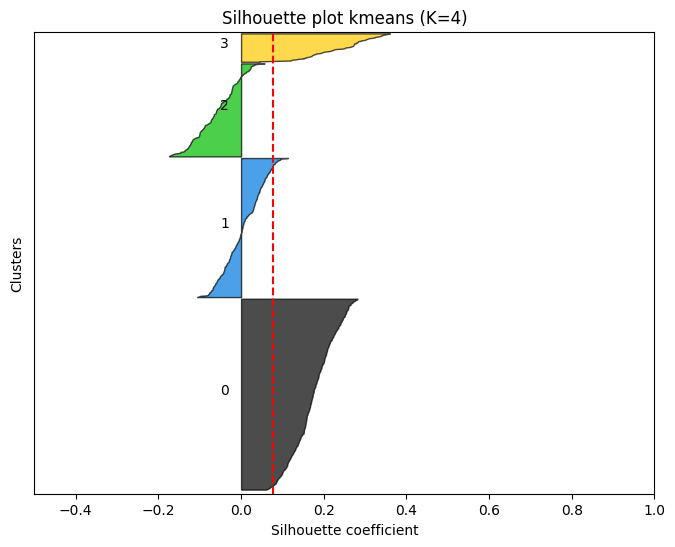

In [10]:
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(8,6))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")
    ax1.set_yticks([]) 
    plt.show()

kms = KMeans(n_clusters=4, random_state=0).fit(df_pca)
drawSillouette(df_pca, kms.labels_, "kmeans (K=4)")

From the plot above we can see that the clustering is not good, even though the scores for cluster 0 and cluster 3 are not bad. Thus, for this reason we decided to compare how different the targets from these two clusters are. To do so, we printted many information about the targets of drugs falling into soecific clusters.

In [11]:
labels, names = zip(*sorted(zip(kms.labels_, molecules)))

print(f'Cluster 0:')
first_cluster = [name for i, name in enumerate(names) if labels[i] == 0]

first_cluster_targets = list(np.concatenate([targets_transactions[molecules.index(drug)] for drug in first_cluster]).flat)
print(f'Number of targets in general: {len(first_cluster_targets)}')
print(f'Number of unique targets: {len(set(first_cluster_targets))}')
element_counts = Counter(first_cluster_targets)
sorted_values = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)[:5]
sort1 = pd.DataFrame(sorted_values, columns=["Target", "Count"])
print("Distribution of drugs binding each target:")
print(sort1.to_string(index=False))

Cluster 0:
Number of targets in general: 4152
Number of unique targets: 858
Distribution of drugs binding each target:
 Target  Count
    REP    251
SLCO1B3    160
SLCO1B1    159
   LMNA    124
 CYP3A4     58


In [12]:
print(f'Cluster 3')
second_cluster = [name for i, name in enumerate(names) if labels[i] == 3]

second_cluster_targets = list(np.concatenate([targets_transactions[molecules.index(drug)] for drug in second_cluster]).flat)
print(f'Number of targets in general: {len(second_cluster_targets)}')
print(f'Number of unique targets: {len(set(second_cluster_targets))}')
element_counts_2 = Counter(second_cluster_targets)
sorted_values_2 = sorted(element_counts_2.items(), key=lambda x: x[1], reverse=True)[:5]
sort2 = pd.DataFrame(sorted_values_2, columns=["Target", "Count"])
print("Distribution of drugs binding each target:")
print(sort2.to_string(index=False))

Cluster 3
Number of targets in general: 492
Number of unique targets: 125
Distribution of drugs binding each target:
 Target  Count
    REP     40
SLCO1B1     36
SLCO1B3     36
  NR3C1     27
    PGR     23


In [13]:
common_for_both = len(set(first_cluster_targets).intersection(set(second_cluster_targets)))
print(f'Number of common unique targets for two clusters: {common_for_both}')
print(f'Number of targets in cluster 0 that do not appear in cluster 3: {len(set(first_cluster_targets)) - common_for_both}')
print(f'Number of targets in cluster 3 that do not appear in cluster 0: {len(set(second_cluster_targets)) - common_for_both}')

Number of common unique targets for two clusters: 98
Number of targets in cluster 0 that do not appear in cluster 3: 760
Number of targets in cluster 3 that do not appear in cluster 0: 27


In [14]:
only_first = list(set(first_cluster_targets).difference(set(second_cluster_targets)))
only_first_counts = {target: count for target, count in element_counts.items() if target in only_first}

# Find the most repeated targets
sorted_values_3 = sorted(only_first_counts.items(), key=lambda x: x[1], reverse=True)
most_repeated = sorted_values_3[:5]  # Get the top 5 most repeated targets

rep1 = pd.DataFrame(most_repeated, columns=["Target", "Count"])

print("Most repeated targets specific for cluster 0 and not cluster 3:")
print(rep1.to_string(index=False))

Most repeated targets specific for cluster 0 and not cluster 3:
 Target  Count
ALDH1A1     32
   TDP1     27
   ACHE     25
  ADRB2     25
  PTGS1     24


In [15]:
only_second = list(set(second_cluster_targets).difference(set(first_cluster_targets)))
only_second_counts = {target: count for target, count in element_counts_2.items() if target in only_second}

# Find the most repeated targets
sorted_values_4 = sorted(only_second_counts.items(), key=lambda x: x[1], reverse=True)
most_repeated_2 = sorted_values_4[:5]  # Get the top 5 most repeated targets

rep2 = pd.DataFrame(most_repeated_2, columns=["Target", "Count"])

print("Most repeated targets specific for cluster 3 and not cluster 0:")
print(rep2.to_string(index=False))

Most repeated targets specific for cluster 3 and not cluster 0:
  Target  Count
   NR3C1     27
    SHBG     12
   NR3C2      9
  GPBAR1      4
SERPINA6      4


# Association Rules

In the second part, using the transaction file (targets of each molecule) we decided to mine association rules. 

In [16]:
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(targets_transactions_ids).transform(targets_transactions_ids)
binary_database = pd.DataFrame(trans_array, columns=tr_enc.columns_)

In [17]:
D={"threshold": [0.1, 0.09, 0.08, 0.07, 0.06, 0.05], 
   "num_itemsets":[],
   "apriori time":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori= apriori(binary_database, min_support = min_supp, use_colnames=True)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori time"].append(t1-t0)

df_performance=pd.DataFrame(D)
df_performance

,threshold,num_itemsets,apriori time
0,0.10,15,0.008130
1,0.09,18,0.008500
2,0.08,24,0.008326
3,0.07,34,0.008014
4,0.06,48,0.008060
5,0.05,95,0.016428


Since apriori algorithm is fast, we did not decide to test any other approaches.

In [18]:
FI_apriori=apriori(binary_database, min_support = 0.06, use_colnames=True) 
FI_apriori['length'] = FI_apriori['itemsets'].apply(lambda x: len(x))
print(FI_apriori.tail(4))
print(f"Number of sets: {FI_apriori.shape[0]}. Maximal size of sets: {max(FI_apriori['length'])}")

     support           itemsets  length
44  0.100000   (1185, 261, 982)       3
45  0.076364   (417, 1185, 982)       3
46  0.064545   (1185, 909, 982)       3
47  0.151818  (1185, 1229, 982)       3
Number of sets: 48. Maximal size of sets: 3


Choosing a threshold of 0.06 for the support, we get 48 rules.
Then we put also thresholds for confidence(> 0.6), lift (> 2) and conviction (> 2), getting a total of 19 rules.

In [19]:
def get_key(my_dict, val):
    keys = []
    for key, value in my_dict.items():
        if value in val:
            keys.append(key)
    return keys

all_rules = association_rules(FI_apriori, metric="confidence", min_threshold=0.6)
all_rules['antecedents'] = all_rules['antecedents'].apply(lambda x: get_key(targets_dict, list(iter(x))))
all_rules['consequents'] = all_rules['consequents'].apply(lambda x: get_key(targets_dict, list(iter(x))))
best_rules = all_rules[(all_rules['lift'] >= 2) & (all_rules['conviction'] >= 2)]
print("Number of Rules:", len(best_rules))
best_rules.sort_values(by=['confidence'], ascending=False)

Number of Rules: 19


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
16,"[CYP3A4, SLCO1B3]",[SLCO1B1],0.064545,0.306364,0.064545,1.000000,3.264095,0.044771,inf
18,"[SLCO1B3, REP]",[SLCO1B1],0.153636,0.306364,0.151818,0.988166,3.225467,0.104750,58.612273
9,[SLCO1B3],[SLCO1B1],0.305455,0.306364,0.298182,0.976190,3.186378,0.204602,29.132727
10,"[LMNA, SLCO1B1]",[SLCO1B3],0.102727,0.305455,0.100000,0.973451,3.186894,0.068621,26.161212
11,"[LMNA, SLCO1B3]",[SLCO1B1],0.102727,0.306364,0.100000,0.973451,3.177438,0.068528,26.126970
8,[SLCO1B1],[SLCO1B3],0.306364,0.305455,0.298182,0.973294,3.186378,0.204602,26.006869
15,"[CYP3A4, SLCO1B1]",[SLCO1B3],0.066364,0.305455,0.064545,0.972603,3.184116,0.044274,25.350909
17,"[SLCO1B1, REP]",[SLCO1B3],0.156364,0.305455,0.151818,0.970930,3.178641,0.104056,23.892364
12,"[SLCO2B1, SLCO1B1]",[SLCO1B3],0.080909,0.305455,0.076364,0.943820,3.089888,0.051650,12.362909
13,"[SLCO2B1, SLCO1B3]",[SLCO1B1],0.080909,0.306364,0.076364,0.943820,3.080719,0.051576,12.346727


From the rules we can see that some rules are really good, as a matter of fact, the first rule [SLCO1B3, CYP3A4] &rarr; [SLCO1B1] has a confidence of 1.0, meaning that, setting a minimum support of 0.06, this transaction happens every time.
It also seems that the variables with similar "name" have meaningful relationships, since rules are: [SLCO1B3] &rarr; [SLCO1B1] and viceversa, [SLCO2B1] &rarr; [SLCO1B3], [HTR2C] &rarr; [HTR2A], [CYP1A2] &rarr; [CYP2D6], just to mention some.

# Recommendation Systems

In the last part we performed recommendation systems to see which drugs were similar between each other by constructing a similarity matrix.

In [20]:
df2 = df.drop(df.columns[0],axis=1)

In [21]:
def RowCenterMatrix(M):
    V  = M.T
    mat= np.nanmean(V, axis=0)
    VC = V - mat
    VC[np.isnan(VC)]=0
    return VC.T

VC=RowCenterMatrix(df2.values)
pd.DataFrame(VC)

def CosSim_Matrix(M):
    norms=np.sqrt(np.sum(M*M, axis=1))
    norms[norms<0.001]=0.001  
    norms_M = np.outer(norms, norms)
    VC=M.copy()
    return np.dot(VC, VC.T)/norms_M

sim_mat = CosSim_Matrix(VC)
sim_molecules=pd.DataFrame(sim_mat, columns=df2.index, index=df2.index)

def get_top_highest(matrix, sort=True, n=5):
    values = []
    for i in range(len(matrix)):
         for j in range(i + 1, len(matrix)):
                values.append((matrix[i][j], i, j))  
    values.sort(reverse=sort)
    top = values[:n]
    return top

top_10_values = get_top_highest(sim_molecules, True, n=10)    

In [22]:
result_df = pd.DataFrame(columns=['Value', 'Coordinates'])

# Iterate over the top 10 values and append to the result DataFrame
for value, i, j in top_10_values:
    result_df = result_df.append({'Value': value, 'Coordinates': (i, j)}, ignore_index=True)

# Style the DataFrame
styled_df1 = (result_df.style
             .set_table_styles([{'selector': 'caption', 'props': [('font-size', '1.2em')]}])
             .set_caption("Most similar drugs:")
             .format(formatter={'Value': '{:.3f}'.format, 'Coordinates': lambda x: '({}, {})'.format(*x)})
             .hide_index())
styled_df1

Value,Coordinates
1.000,"(549, 735)"
1.000,"(441, 704)"
1.000,"(865, 866)"
1.000,"(551, 661)"
1.000,"(376, 1099)"
1.000,"(286, 556)"
1.000,"(283, 642)"
1.000,"(216, 369)"
1.000,"(187, 1061)"
1.000,"(139, 547)"


We then created a recommendation system to see for each molecules the most similar ones.

In [23]:
sims=pd.DataFrame(sim_molecules)

np.fill_diagonal(sims.values, -999)

def precompute_similars(DB, sims, K=5):
    similars=[]
    for idi, item in enumerate(DB):
        sim_item_idxs = sims[idi].argsort()[:-(K+1):-1]
        sim_items = [(sims[idi][i], i) for i in sim_item_idxs]
        similars.append(sim_items)
    return similars

similars=precompute_similars(molecules, sim_mat)

def recommend(db, similars, molecule_id, num=2):
    print("Recommending " + str(num) + " items similar to: " + db[molecule_id] + f'      t: [{targets_transactions[molecule_id]}]')
    for rec in similars[molecule_id][:num]:
        print("\t      (score: %7.4f) - %s" % (rec[0], db[rec[1]]) + f'      t: [{targets_transactions[molecules.index(db[rec[1]])]}]')

We decided to print recommended drugs, as well as their targets, for most similar ones from the previosuly computed similarity matrix.

In [24]:
recommend(molecules, similars, molecule_id=549,num=4)

Recommending 4 items similar to: PDFDA0550      t: [['KCNH2']]
	      (score:  1.0000) - PDFDA0736      t: [['KDM4E', 'SKA', 'HPGD', 'SLC22A1']]
	      (score:  0.5161) - PDFDA0452      t: [['GYRA', 'PARC', 'SKA']]
	      (score:  0.4909) - PDFDA0573      t: [['SETD7']]
	      (score:  0.4615) - PDFDA0683      t: [['PARC']]


In [25]:
recommend(molecules, similars, molecule_id=735,num=4)

Recommending 4 items similar to: PDFDA0736      t: [['KDM4E', 'SKA', 'HPGD', 'SLC22A1']]
	      (score:  1.0000) - PDFDA0550      t: [['KCNH2']]
	      (score:  0.5161) - PDFDA0452      t: [['GYRA', 'PARC', 'SKA']]
	      (score:  0.4909) - PDFDA0573      t: [['SETD7']]
	      (score:  0.4615) - PDFDA0683      t: [['PARC']]


As expected highly similar drugs share the set of similar drugs. We can also have an insight on their targets.

More detailed outile, as well as description of the results, is contained in the report.